# Music Genre Classification:

## Importing Libraries:

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import scipy
import tarfile
import os
from pathlib import Path
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import subprocess
import IPython.display as ipd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import scikitplot
import seaborn as sns
import warnings
from python_speech_features import mfcc
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

## Creating Combined Features:

In [6]:
# Generating labels.
genres_labels = dict()
cnt = 0
# Loop through each class and assign a numerical value.
for folder in os.listdir("data/genres/"):
    genres_labels[folder] = cnt
    cnt += 1
    
genres_labels

{'blues': 9,
 'classical': 2,
 'country': 7,
 'disco': 3,
 'hiphop': 6,
 'jazz': 4,
 'metal': 5,
 'pop': 1,
 'reggae': 0,
 'rock': 8}

In [7]:
# Generating FFT Feature function.
def feature_class_generator(audio_file_path, class_name):
    # Read audio file from path provided
    rate, audio = wav.read(audio_file_path)
    
    # Get fft features (only top 1000)
    fft_features = np.array(abs(scipy.fft(audio)[:1000]))
    
    mfcc_features = mfcc(audio)
    
    # our mfcc feature contains 13 values for each frame in our audio file.
    # the total number of frames is 4100 approx value. We want to reduce this as this would overwhelm our model.
    # To do this we ignore 10% starting and 10% ending song and take mean of all the frames
    frames = mfcc_features.shape[0] # Get all frames
    mfcc_features = np.mean(mfcc_features[int(frames*0.1):int(frames*0.9)], axis = 0) # take mean
    
    
    # Combine Features:
    feature = np.append(fft_features, mfcc_features)
    
    # Return features and label
    return feature, genres_labels[class_name]

In [8]:
# Getting the features corresponding to each file.

features = [] # Holds features for every wav file.
labels = [] # Holds labels for every wav file.

# Loop through each folder
for folder in os.listdir("data/genres/"):
    
    # Loop through each file
    for filename in os.listdir("data/genres/"+folder+"/"):

        # Get feaure and label for the file.
        feature, label = feature_class_generator("data/genres/"+folder+"/"+filename, folder)
        
        # Store feature and label seperatly
        features.append(feature)
        labels.append(label)
        
    print(folder + " genre processing done")
print(len(features))
print(len(labels))

reggae genre processing done
pop genre processing done
classical genre processing done
disco genre processing done
jazz genre processing done
metal genre processing done
hiphop genre processing done
country genre processing done
rock genre processing done
blues genre processing done
1000
1000


In [9]:
# Create a dataframe out of features and labels, shuffle them then store them.
df = pd.DataFrame(features)
df['label'] = labels
df = shuffle(df)
df = shuffle(df)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
df.to_pickle("Combined_Features.pkl")

In [16]:
df = pd.read_pickle("Combined_Features.pkl")
labels = df['label']
df.drop(columns = ['label'], inplace=True)
label_to_genre = ['reggae', 'pop', 'classical', 'disco', 'jazz', 'metal', 'hiphop', 'country', 'rock', 'blues']
# Randomly seperate data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.3, random_state=0) 
minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)


print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(700, 1013)
(300, 1013)
700
300


## Metric Functions:

In [18]:
# this function uses heatmap of seaborn library to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    confusion_df = pd.DataFrame(data=cm, columns=label_to_genre, index=label_to_genre)
    fig1=plt.figure(figsize=(15,7))
    plt.title("Not Normalized Confusion Matrix")
    sns.heatmap(confusion_df, annot=True)
    plt.show()
    fig1.savefig(name)
    fig2=plt.figure(figsize=(15,7))
    plt.title("Normalized Confusion Matrix")
    sns.heatmap(confusion_df/confusion_df.sum(axis=1), annot=True)
    plt.show()
    fig2.savefig(name+" Normalized")

In [19]:
# this function uses the scikitplot library to plot ROC_AUC Curve.
def plot_roc_auc_curve(y_test, y_proba_pred, name):
    fig, ax = plt.subplots(figsize=(15,7))
    scikitplot.metrics.plot_roc_curve(y_test, y_proba_pred, ax=ax)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(name, bbox_inches=extent.expanded(1.1, 1.2))

## Logistic Regression:

In [20]:
# For hyperparameter tuning.
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l2', 'l1']

# For plotting.
xticks = []
rocauc_scores = []

for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        
        # fit / Train
        lr = LogisticRegression(multi_class='ovr',C=a,penalty=p,max_iter=10000,verbose = 1,n_jobs = -1)
        lr.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = lr.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

[LibLinear]1e-05 l2:  0.6748560541562912
[LibLinear]1e-05 l1:  0.5
[LibLinear]0.0001 l2:  0.678997755156965
[LibLinear]0.0001 l1:  0.5
[LibLinear]0.001 l2:  0.697770053357075
[LibLinear]0.001 l1:  0.5
[LibLinear]0.01 l2:  0.7413254009285744
[LibLinear]0.01 l1:  0.5
[LibLinear]0.1 l2:  0.8335187251008029
[LibLinear]0.1 l1:  0.7408270383770468
[LibLinear]1 l2:  0.8839154972969544
[LibLinear]1 l1:  0.8952767521125651
[LibLinear]10 l2:  0.8801781480210442
[LibLinear]10 l1:  0.8593875827038572
[LibLinear]100 l2:  0.8597370143278578
[LibLinear]100 l1:  0.8115513956140568
[LibLinear]1000 l2:  0.8409516601412742
[LibLinear]1000 l1:  0.78837088378537


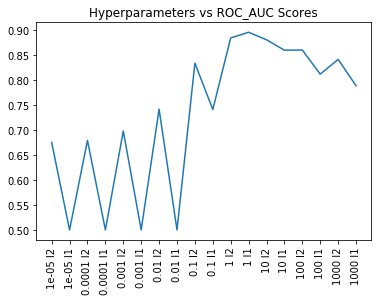

In [21]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("LR_Combined_hyperparameters_vs_roc_auc")

In [22]:
# Training the Model with best parameters found.
C = 1 # From graph.
p = 'l1' # From graph.
lr = LogisticRegression(C=C, penalty=p, solver='liblinear', multi_class='ovr', max_iter=10000, n_jobs = -1)
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=-1, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

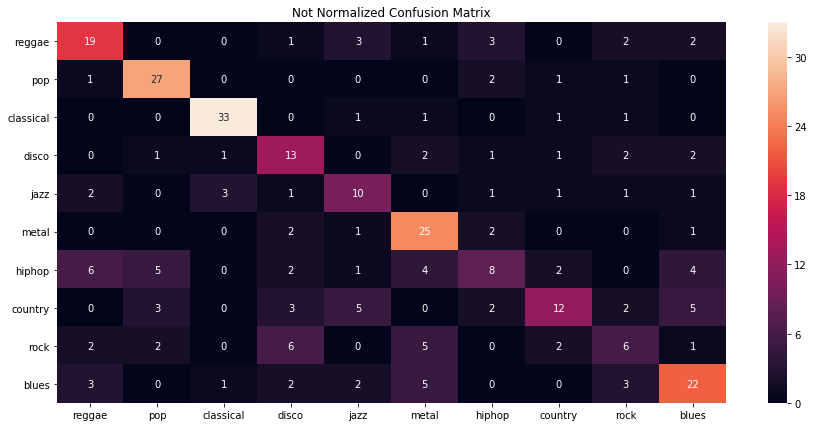

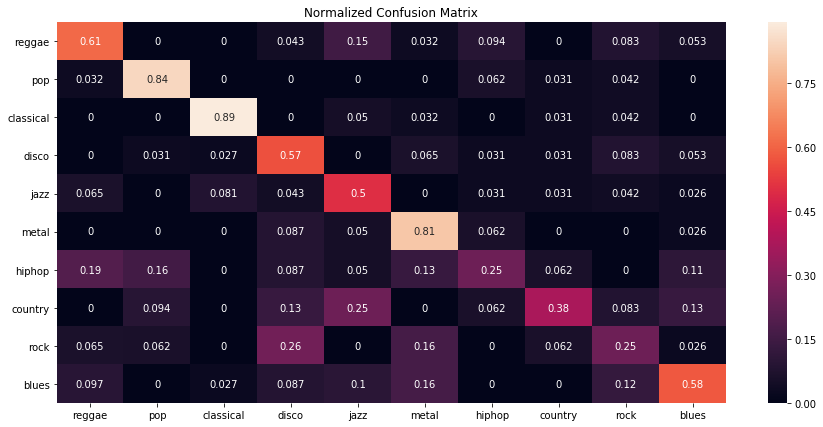

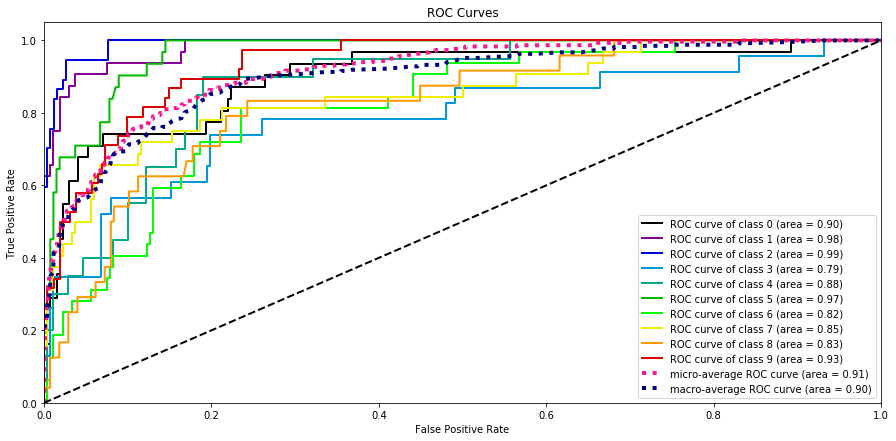

In [23]:
# Getting the confusion matrix.
y_pred = lr.predict(X_test)
y_proba_pred = lr.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "LR_Combined_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "LR_Combined_ROC_AUC_Curve")

## Random Forest:

In [24]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        rf = RandomForestClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        rf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = rf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.8181680257573261
Estimators:30 MaxDepth:5:  0.8037213172597155
Estimators:30 MaxDepth:7:  0.8336371323900813
Estimators:50 MaxDepth:3:  0.8056358273375194
Estimators:50 MaxDepth:5:  0.8058206538473514
Estimators:50 MaxDepth:7:  0.8221939304311116
Estimators:100 MaxDepth:3:  0.8062487054364155
Estimators:100 MaxDepth:5:  0.8349931646381702
Estimators:100 MaxDepth:7:  0.8359407958039087
Estimators:300 MaxDepth:3:  0.8134311695879889
Estimators:300 MaxDepth:5:  0.8416298373774742
Estimators:300 MaxDepth:7:  0.8584763998178989
Estimators:500 MaxDepth:3:  0.8115243832085637
Estimators:500 MaxDepth:5:  0.8420450935769347
Estimators:500 MaxDepth:7:  0.8577807301547047


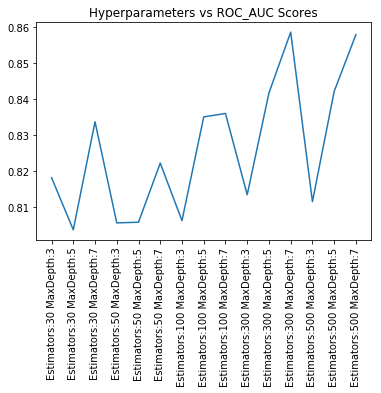

In [25]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("RF_Combined_Hyperparameters_vs_roc_auc")

In [26]:
# Training the Model with best parameters found.
estim = 300 # From graph.
dep = 7 # From graph.
rf = RandomForestClassifier(n_estimators=estim, max_depth=dep)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

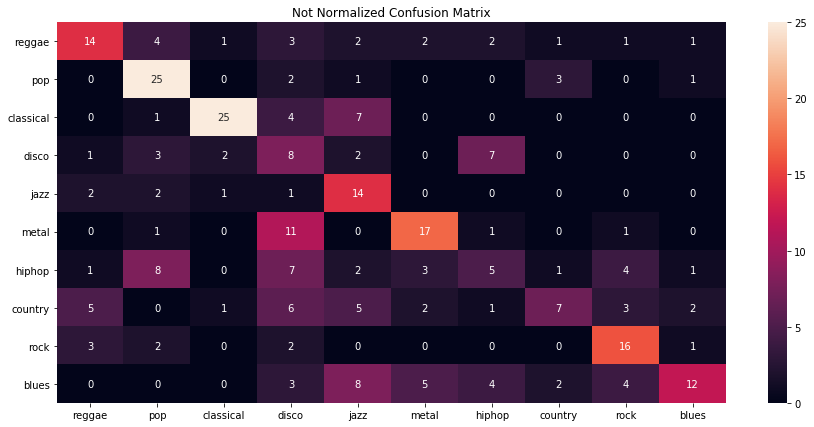

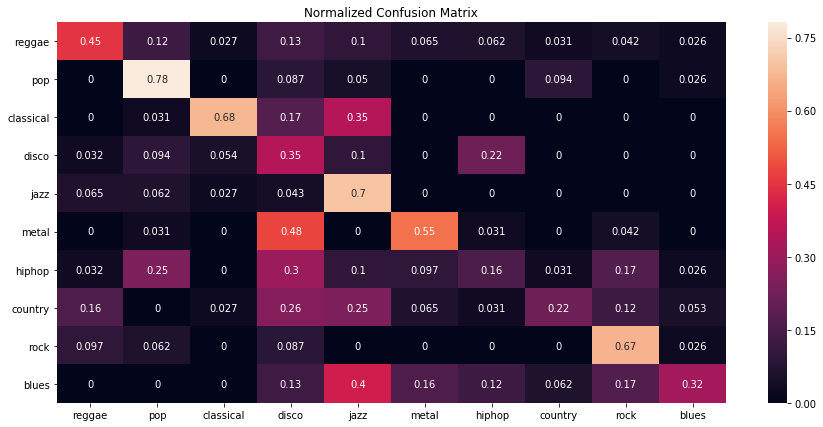

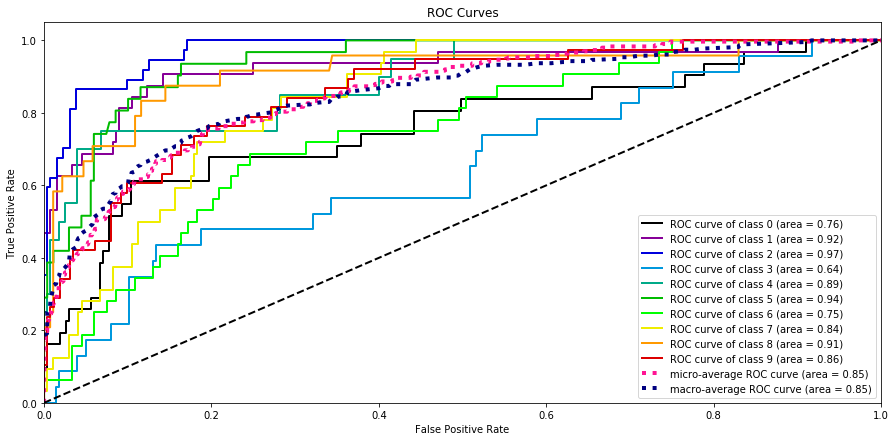

In [27]:
# Getting the confusion matrix.
y_pred = rf.predict(X_test)
y_proba_pred = rf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "RF_Combined_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "RF_Combined_ROC_AUC_Curve")

## XGBClassifier:

In [28]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        xgbcf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = xgbcf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.896475066623435
Estimators:30 MaxDepth:5:  0.9003105594504456
Estimators:30 MaxDepth:7:  0.9038511071604971
Estimators:50 MaxDepth:3:  0.9071602678958707
Estimators:50 MaxDepth:5:  0.914028009912211
Estimators:50 MaxDepth:7:  0.9158316390330269
Estimators:100 MaxDepth:3:  0.9215036269055833
Estimators:100 MaxDepth:5:  0.9222033182204811
Estimators:100 MaxDepth:7:  0.9234109113943504
Estimators:300 MaxDepth:3:  0.9312480275493169
Estimators:300 MaxDepth:5:  0.9295911113336202
Estimators:300 MaxDepth:7:  0.9299086041427334
Estimators:500 MaxDepth:3:  0.9317847191881494
Estimators:500 MaxDepth:5:  0.929734893429008
Estimators:500 MaxDepth:7:  0.9300925489963998


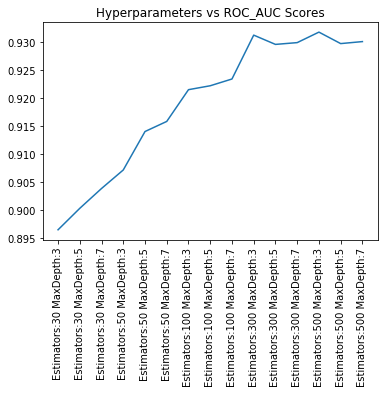

In [29]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("XgBoost_Combined_Hyperpaameters_vs_roc_auc")

In [30]:
# Training the Model with best parameters found.
estim = 500 # From graph.
dep = 3 # From graph.
xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
xgbcf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

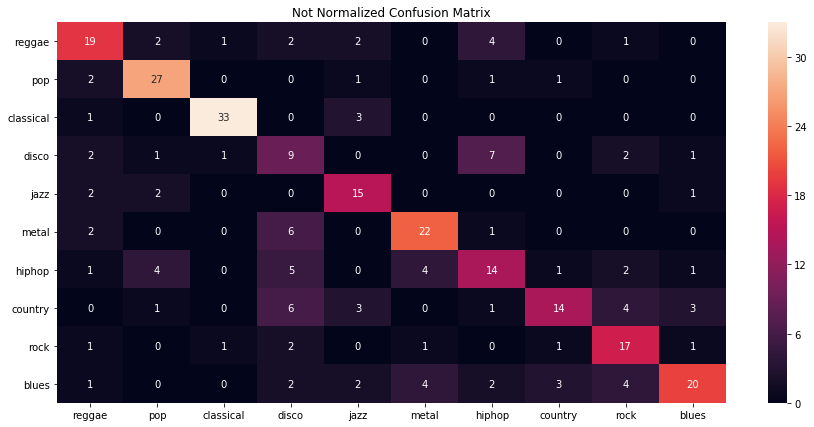

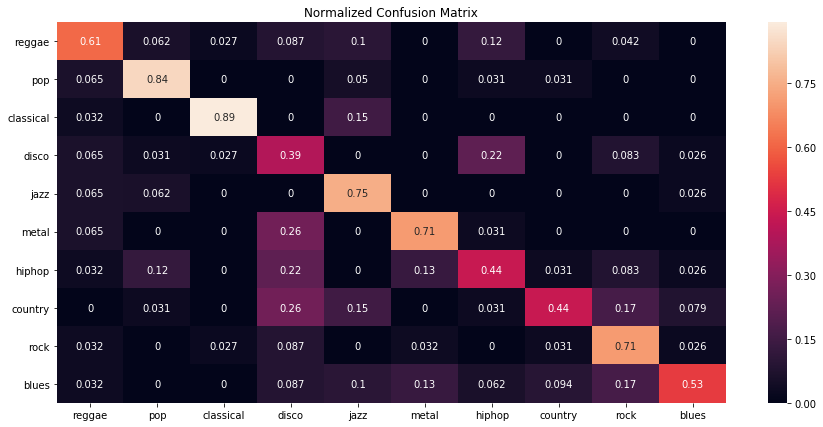

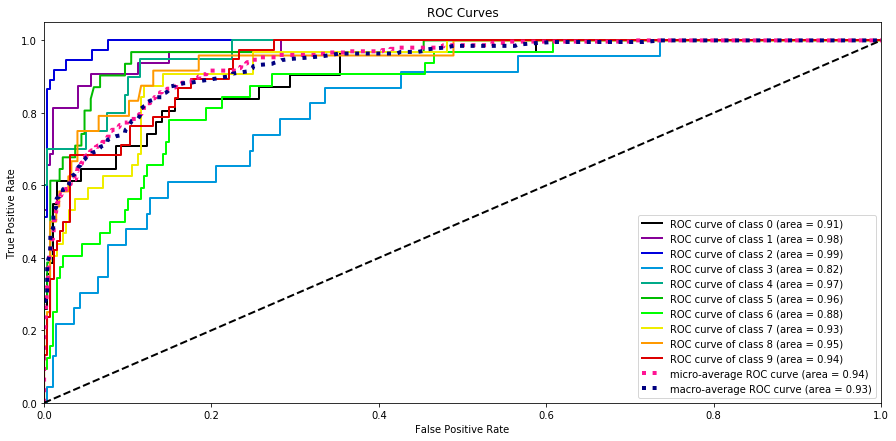

In [31]:
# Getting the confusion matrix.
y_pred = xgbcf.predict(X_test)
y_proba_pred = xgbcf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "XgBoost_Combined_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "XgBoost_Combined_ROC_AUC_Curve")